In [1]:
import os
os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # deterministic GPU ops
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"  # deterministic cuDNN kernels

import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, average_precision_score, recall_score, precision_score

# Set the seeds for reproducibility
import random
SEED = 2648509283
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

/Users/eugeneshevchenko/Courses/RD_Computer-Vision/HW/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
best_params_stored = {
    'class_weight_mode': 'none',
    'class_weight': None,
    'lr': 3.3387623209003863e-05,
    'batch': 96,
    'kernel_size_1': 3,
    'dropout': 0.320155349263217,
    'l2': 3e-05,
    'rot': 0.027426345331384744,
    'zoom': 0.07278331883010884,
    'contrast': 0.08144623991276302,
    'brightness': 8.359473926114816e-05
}

In [3]:
"""
Images will be resized to 80x80
Model class_weight will stay default. The dataset is imbalanced, but moderately - positive class (PNEUMONIA) has only 2.5 times more CXR images than negative (NORMAL).
"""

DATASET_DIR = "../data/chest_xray"
DATASET_PATH = Path(DATASET_DIR)
TRAIN_PATH = DATASET_PATH / "train"
TEST_PATH = DATASET_PATH / "test"
CLASSES = ["NORMAL", "PNEUMONIA"]
ID_TO_CLASS = {0:'NORMAL', 1:'PNEUMONIA'}
IMG_SIZE_SIDE = 80
IMG_SIZE = (IMG_SIZE_SIDE, IMG_SIZE_SIDE)
BATCH = best_params_stored['batch']
VAL_FRACTION = 0.15
PAD_TO_ASPECT_RATIO=False
CLASS_WEIGHTS = best_params_stored['class_weight']

In [4]:
"""
Split test images in Train folder into Train/Val sets
We don't use existing Val folder because it has extremely small amount data
"""

train_ds, val_ds = keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    labels='inferred',
    class_names=CLASSES,
    label_mode='binary',
    color_mode='grayscale',
    image_size=IMG_SIZE,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=PAD_TO_ASPECT_RATIO,
    batch_size=BATCH,
    validation_split=VAL_FRACTION,
    subset='both',
    shuffle=True,
    seed=SEED,
)

Found 5216 files belonging to 2 classes.
Using 4434 files for training.
Using 782 files for validation.


2025-11-13 11:14:42.728882: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-13 11:14:42.728944: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-13 11:14:42.728950: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-13 11:14:42.729322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-13 11:14:42.729346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
"""
Build Test set using images fron Test folder
"""

test_ds = keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    labels='inferred',
    class_names=CLASSES,
    label_mode='binary',
    color_mode='grayscale',
    image_size=IMG_SIZE,
    pad_to_aspect_ratio=PAD_TO_ASPECT_RATIO,
    batch_size=BATCH,
    shuffle=False,
)

Found 624 files belonging to 2 classes.


In [6]:
"""
Standardizing the input images - adjust the contrast and brightness to standard range
"""

NORM = layers.Normalization(name="norm")

train_images = train_ds.map(lambda x, _: x, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
NORM.adapt(train_images)

2025-11-13 11:15:27.658060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
"""
###  VGG-style CNN with a GAP head  ###
...
"""

def build_cnn(input_shape=(IMG_SIZE_SIDE, IMG_SIZE_SIDE, 1)):
    l2 = best_params_stored['l2']
    reg = keras.regularizers.l2(l2) if l2 and l2 > 0 else None

    inputs = keras.Input(shape=input_shape)

    x = layers.RandomRotation(best_params_stored['rot'], fill_mode="constant", seed=SEED)(inputs)
    x = layers.RandomZoom(best_params_stored['zoom'], fill_mode="constant", seed=SEED)(x)
    x = layers.RandomContrast(best_params_stored['contrast'], seed=SEED)(x)
    x = layers.RandomBrightness(best_params_stored['brightness'], seed=SEED)(x)

    # Use adapted stats
    x = NORM(x)

    x = layers.Conv2D(32, best_params_stored['kernel_size_1'], strides=2, padding='same', use_bias=False, kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False, kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same', use_bias=False, kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, padding='same', use_bias=False, kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(best_params_stored['dropout'], seed=SEED)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs, x)

model = build_cnn()
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve='PR', name='AUC_PR'),
        keras.metrics.AUC(curve='ROC', name='AUC_ROC'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.F1Score(name='F1'),
        keras.metrics.FBetaScore(name='F2', beta=2.0),
    ],
)

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 80, 80, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 80, 80, 1)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_2             │ (None, 80, 80, 1)      │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm (Normalization)            │ (None, 80, 80, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           12

 Total params: 241,444 (943.14 KB)

 Trainable params: 240,737 (940.38 KB)

 Non-trainable params: 707 (2.77 KB)

In [13]:
# Performance optimisations
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [14]:
# Validation metric
monitor_metric = "val_AUC_PR"

early = keras.callbacks.EarlyStopping(
    monitor=monitor_metric,
    mode="max",
    patience=6,
    restore_best_weights=True,
)

ckpt = keras.callbacks.ModelCheckpoint(
    "../model/model-2-cv.keras",
    monitor=monitor_metric,
    mode="max",
    save_best_only=True,
)

rlr = keras.callbacks.ReduceLROnPlateau(
    monitor=monitor_metric,
    mode="max",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
)

tb = keras.callbacks.TensorBoard(log_dir="../logs/tb_logs_cv", histogram_freq=0)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=CLASS_WEIGHTS,
    callbacks=[early, ckpt, rlr, tb],
)

Epoch 1/100


2025-11-13 11:26:11.109928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - AUC_PR: 0.9553 - AUC_ROC: 0.8798 - F1: 0.8545 - F2: 0.9362 - loss: 0.3833 - precision: 0.8883 - recall: 0.9077 - val_AUC_PR: 0.9631 - val_AUC_ROC: 0.9014 - val_F1: 0.8483 - val_F2: 0.9332 - val_loss: 0.8467 - val_precision: 0.7366 - val_recall: 1.0000 - learning_rate: 3.0000e-04
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - AUC_PR: 0.9871 - AUC_ROC: 0.9633 - F1: 0.8545 - F2: 0.9362 - loss: 0.2320 - precision: 0.9448 - recall: 0.9474 - val_AUC_PR: 0.9940 - val_AUC_ROC: 0.9835 - val_F1: 0.8483 - val_F2: 0.9332 - val_loss: 0.2723 - val_precision: 0.8324 - val_recall: 1.0000 - learning_rate: 3.0000e-04
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - AUC_PR: 0.9899 - AUC_ROC: 0.9731 - F1: 0.8545 - F2: 0.9362 - loss: 0.1943 - precision: 0.9543 - recall: 0.9578 - val_AUC_PR: 0.9934 - val_AUC_ROC: 0.9813 - val_F1: 0.8483 - val_F2: 0.9332 - val_loss: 0.3751 - val_precision: 0.9933 - val_recall: 0.7708 - learning_rate: 3.0000e-04
Epo

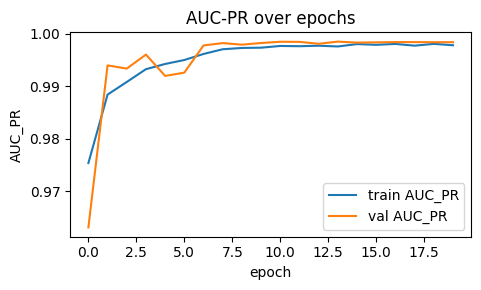

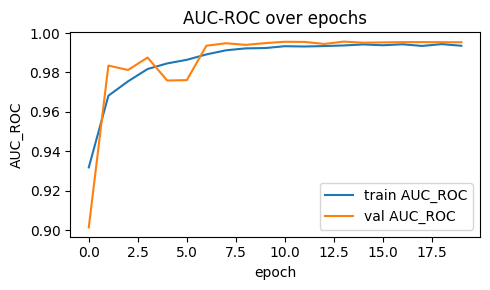

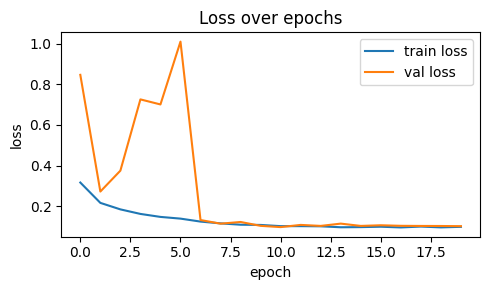

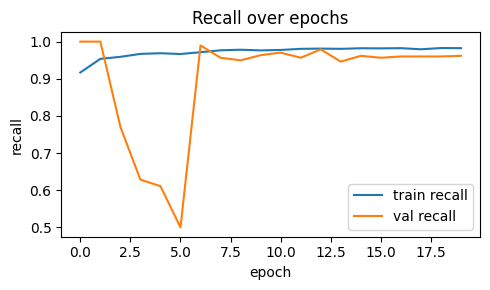

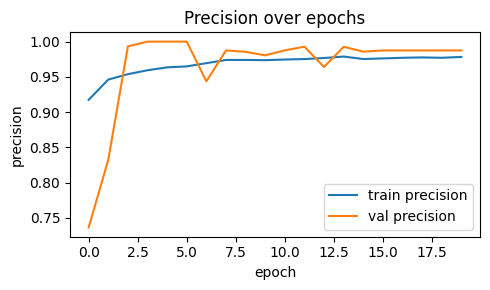

In [15]:
def plot_metric(h, key, title=None):
    plt.figure(figsize=(5,3))
    plt.plot(h.history[key], label=f"train {key}")
    val_key = f"val_{key}" if f"val_{key}" in h.history else None
    if val_key: plt.plot(h.history[val_key], label=f"val {key}")
    plt.xlabel("epoch"); plt.ylabel(key);
    if title: plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

plot_metric(history, "AUC_PR", "AUC-PR over epochs")
plot_metric(history, "AUC_ROC", "AUC-ROC over epochs")
plot_metric(history, "loss", "Loss over epochs")
plot_metric(history, "recall", "Recall over epochs")
plot_metric(history, "precision", "Precision over epochs")

In [39]:
"""
Coosing the Threshold by the target value - Desired Recall is 94%
"""

def threshold_for_recall(y_true, y_prob, min_recall=0.94):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    # Find all thresholds meeting the recall constraint
    ok = np.where(rec >= min_recall)[0]
    # cannot hit target recall
    if len(ok) == 0:
        # best achievable recall
        i = np.argmax(rec)
        t = thr[max(i-1, 0)]
        return t, prec[i], rec[i]
    # highest threshold with recall >= target
    i = ok[-1]
    # align index
    t = thr[max(i-1, 0)]
    return t, prec[i], rec[i]


y_true = np.concatenate([y.numpy().ravel() for _,y in val_ds])
y_prob = model.predict(val_ds, verbose=0).ravel()

best_t_target, prec, rec = threshold_for_recall(y_true, y_prob)

print(f"{'Threshold':15s}: {best_t_target:.4f}")
print(f"{'Recall':15s}: {rec:.4f}")
print(f"{'Precision':15s}: {prec:.4f}")

2025-11-13 11:35:53.419428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Threshold      : 0.5683
Recall         : 0.9410
Precision      : 0.9963


In [40]:
"""
Model evaluation on Validation set
"""

best_t = best_t_target

# Get built-in metrics from model
val_metrics = model.evaluate(val_ds, verbose=0)
metric_names = model.metrics_names

print("\n--- Built-in Metrics ---")
for name, value in zip(metric_names, val_metrics):
    print(f"{name:15s}: {value:.4f}")

val_probs = model.predict(val_ds, verbose=0).ravel()
val_labels = np.concatenate([y.numpy().ravel() for _, y in val_ds.unbatch()])
val_preds = (val_probs >= best_t).astype(int)

recall = recall_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
accuracy = accuracy_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)
roc_auc = roc_auc_score(val_labels, val_probs)
pr_auc = average_precision_score(val_labels, val_probs)

print(f"\n--- Additional Metrics (threshold={best_t:.4f}) ---")
print(f"{'Recall':15s}: {recall:.4f}")
print(f"{'Precision':15s}: {precision:.4f}")
print("-----")
print(f"{'Accuracy':15s}: {accuracy:.4f}")
print(f"{'F1-Score':15s}: {f1:.4f}")
print(f"{'ROC-AUC':15s}: {roc_auc:.4f}")
print(f"{'PR-AUC (AP)':15s}: {pr_auc:.4f}")


--- Built-in Metrics ---
loss           : 0.1145
compile_metrics: 0.9985

--- Additional Metrics (threshold=0.5683) ---
Recall         : 0.9427
Precision      : 0.9963
-----
Accuracy       : 0.9552
F1-Score       : 0.9688
ROC-AUC        : 0.9956
PR-AUC (AP)    : 0.9985


2025-11-13 11:35:59.156572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
# Load model
loaded_model = keras.models.load_model("../model/model-2-cv.keras")

# Run predictions on Test set
probs = loaded_model.predict(test_ds, verbose=0).ravel()
y_true = np.concatenate([y.numpy().ravel() for _, y in test_ds])

2025-11-13 11:36:03.251145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
"""
Get binary predictions by applying best threshold
"""

threshold = best_t_target
y_pred = (probs >= threshold).astype(int)

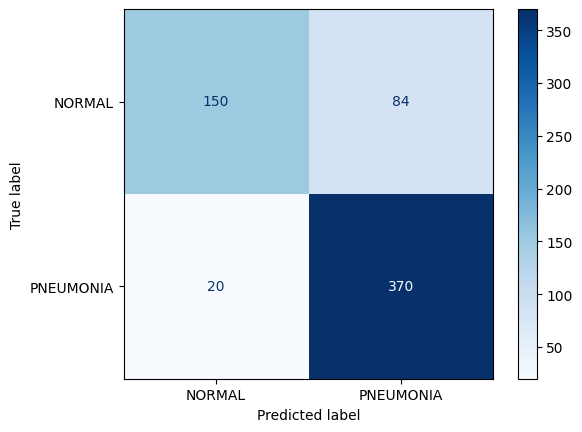

In [43]:
"""
Looking at Confusion matrix
"""

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(values_format='d', cmap='Blues');

In [44]:
TN, FP, FN, TP = cm.ravel()

# Sensitivity (don’t miss pneumonia)
recall = TP / (TP + FN) if (TP + FN) else 0.0
precision = TP / (TP + FP) if (TP + FP) else 0.0

print(f"Threshold={threshold:.3f}  Recall={recall:.3f}  Precision={precision:.3f}")

Threshold=0.568  Recall=0.949  Precision=0.815


---

Compared to the baseline model (the 1st model) we made thinks worse:
- Recall: `94.9%` compared to the baseline `96.7%`
- Precision: `81.5%` compared to the baseline `81.4%`

The Pneumonia class prediction Recall is dropped.